# Logistic Regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.special import expit as invlogit

In [2]:
az.style.use('arviz-darkgrid')
np.random.seed(1234)

## Load and examine American National Election Studies (ANES) data
These data are from the 2016 pilot study. The full study consisted of 1200 people, but here we've selected the subset of 487 people who responded to a question about whether they would vote for Hillary Clinton or Donald Trump. 

In [3]:
data = pd.read_csv('data/ANES_2016_pilot.csv')
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is `vote`, which gives peoples' responses to the following question prompt:

_"If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?"_

In [4]:
data['vote'].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

The two predictors we'll examine are a respondent's `age` and their political party affiliation, `party_id`, which is their response to the following question prompt:

_"Generally speaking, do you usually think of yourself as a Republican, a Democrat, an
independent, or what?"_

In [5]:
data['party_id'].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

These two predictors are somewhat correlated, but not all that much:

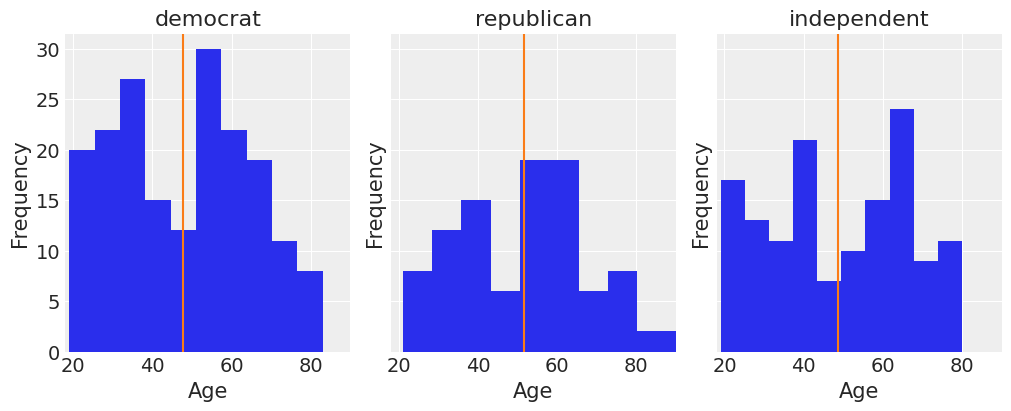

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data['party_id'].unique(), range(3)))
for label, df in data.groupby('party_id'):
    ax[key[label]].hist(df['age'])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel('Age')
    ax[key[label]].set_ylabel('Frequency')
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df['age'].mean(), color='C1')

We can get a pretty clear idea of how party identification is related to voting intentions by just looking at a contingency table for these two variables:

In [7]:
pd.crosstab(data['vote'], data['party_id'])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


But our main question here will be: How is respondent age related to voting intentions, and is this relationship different for different party affiliations? For this we will use a logistic regression.

## Build `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [8]:
clinton_data = data.loc[data['vote'].isin(['clinton', 'trump']), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


### Logistic regression
We'll use a logistic regression model to estimate the probability of voting for Clinton as a function of age and party affiliation. We can think we have a response variable $Y$ defined as

$$Y = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person votes for Clinton} \\
        0 & \textrm{if the person votes for Trump} 
    \end{array}
\right.
$$

and we are interested in modelling $\pi = P(Y = 1)$ (a.k.a. probability of success) based on two explanatory variables, age and party affiliation. 

A logistic regression is a model that links the $\text{logit}(\pi)$ to a linear combination of the predictors. In our example, we're going to include a main effect for party affiliation and the interaction effect between party affiliation and age (i.e. we'll have a different age slope for each affiliation). The mathematical equation for our model is

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = 
\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 X_4 + \beta_4 X_1 X_4 + \beta_5 X_2 X_4
$$

$
X_1 = \left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Independent} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
X_2 = \left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Republican} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if party affiliation is Democrat} \\
        0 & \textrm{in other case} 
    \end{array}
\right. \\
X_4 = \text{Age}
$ 

Notice we don't have a main effect for $X_3$. This happens because Democrat party affiliation is being taken as baseline and $\beta_1$ and $\beta_2$ represent deviations from that baseline. Thus, we see the main effect of Democrat affiliation is being represented by the Intercept, $\beta_0$. 

If we represent the right hand side of the model equation with $\eta$, the expression can be re-arranged to express our probability of interest, $\pi$, as a function of the linear predictor $\eta$.

$$\pi = \frac{e^\eta}{1 + e^\eta}= \frac{1}{1 + e^{-\eta}}$$

Since we're Bayesian folks who draw samples from posteriors, we need to specify a prior for the parameters as well as a likelihood function before accomplishing our task. In this occasion, we're going to use the default priors in Bambi and just note the likelihood is the product of $n$ Bernoulli trials, $\prod_{i=1}^{n}{p_i^y(1-p_i)^{1-y_i}}$ where $p_i = P(Y=1)$ and $y_i = 1$ if the vote intention is for Clinton and $y_i = 0$ if Trump.

### Specify and fit model in Bambi
Specifying and fitting the model is simple. Bambi is good and doesn't ask us to translate all the math to code. We just need to specify our model using the formula syntax and pass the correct `family` argument. Notice the (optional) syntax that we use on the left-hand-side of the formula: We say `vote[clinton]` to instruct Bambi that we wish the model the probability that `vote=='clinton'`, rather than the probability that `vote=='trump'`. If we leave this unspecified, Bambi will just pick one of the events to model, but will inform you which one it picked when you build the model (and again when you look at model summaries).

On the right-hand-side of the formula we use `pary_id + party_id:age` to instruct Bambi that we want to use `party_id` and the interaction between `party_id` and `age` as the explanatory variables in the model.

<!--When fitting models using the `pymc3` backend, the default estimation strategy is to start with an identity mass matrix, but add uniform jitter in [-1, 1] and then adapt a diagonal based on the variance of the tuning draws. This generally works quite well, but occasionally it can fails. That's what was happening for this particular data set and model, so below we disable the `jitter+adapt_diag` initialization by changing from `init='auto'` (the default) to `init=adapt_diag`, which tells the `pymc3` backend to drop the jitter step.-->

In [9]:
clinton_model = bmb.Model(clinton_data)
clinton_fitted = clinton_model.fit('vote[clinton] ~ party_id + party_id:age', 
                                   family='bernoulli', draws=2000)

/home/tomas/anaconda3/envs/bmb/lib/python3.8/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 15 seconds.
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '9084' (I am process '8817')


To see the sensitive default priors Bambi has chosen for us, we just call `Model.plot_priors()`.

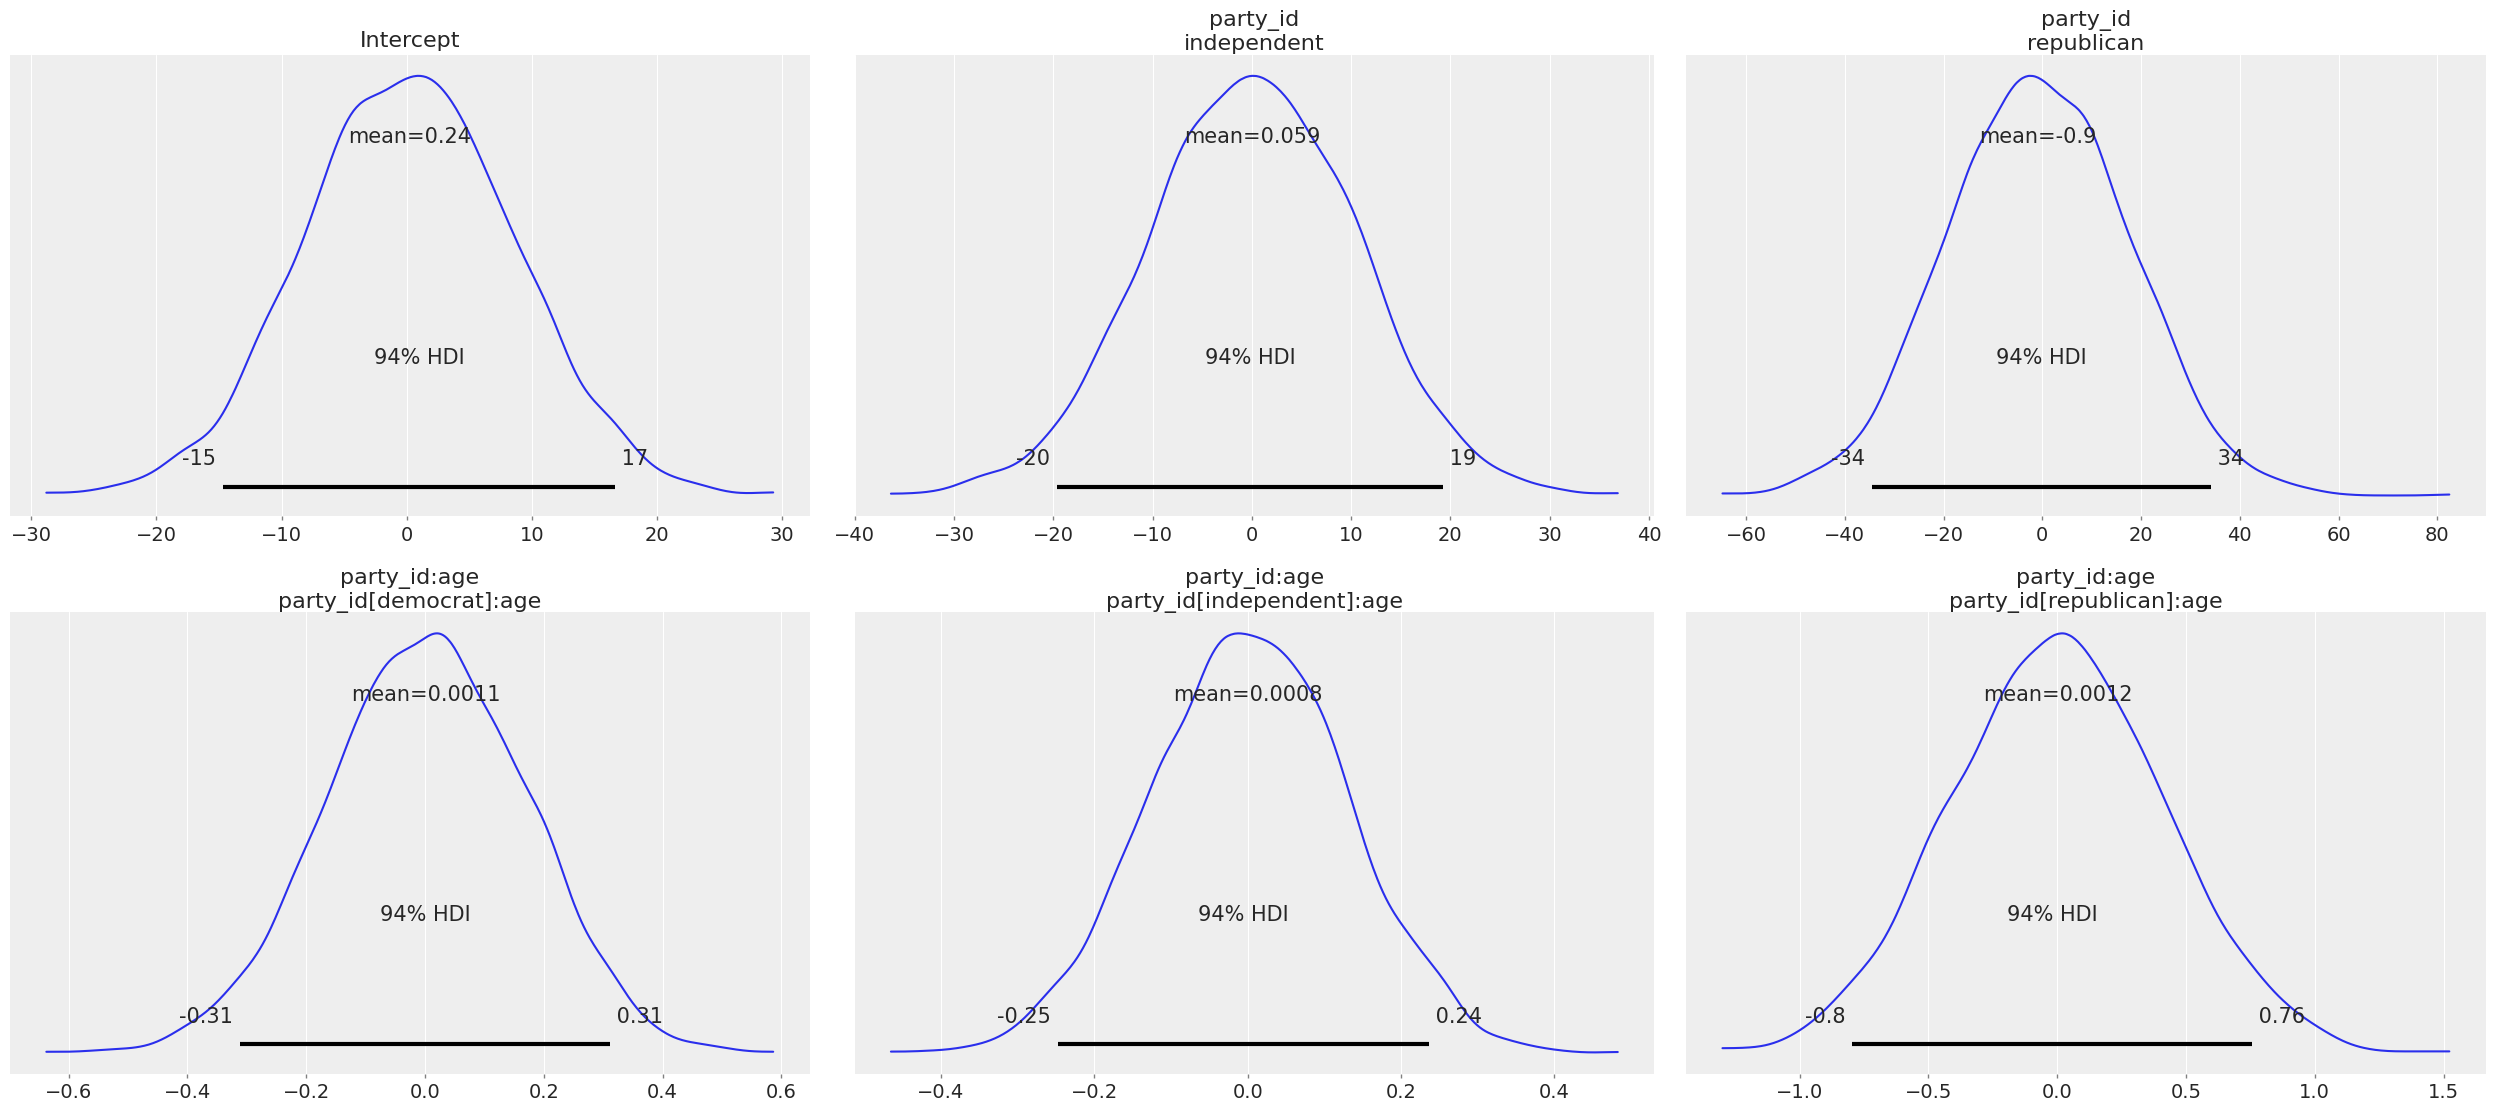

In [10]:
clinton_model.plot_priors();

Here we also inspect the parameters Bambi chosen for each prior.

In [11]:
{x.name: x.prior.args for x in clinton_model.terms.values()}

{'Intercept': {'mu': array(0.308043), 'sigma': array(8.39859892)},
 'party_id': {'mu': array([0, 0]), 'sigma': array([10.51415445, 18.72417819])},
 'party_id:age': {'mu': array([0, 0, 0]),
  'sigma': array([0.16748696, 0.12909332, 0.40771782])}}

Under the hood, Bambi selected Gaussian priors for all the parameters in the model. By construction, all the priors, except the one for `Intercept`, are centered around 0, which is consistent with the desired weakly informative behavior. The standard deviation is specific to each parameter. 

Some more info about these default priors can be found in [this technical paper](https://arxiv.org/abs/1702.01201).

Now let's check out the the results! We get traceplots and density estimates for the posteriors with `az.plot_trace()` and a summary of the posteriors with `az.summary()`.

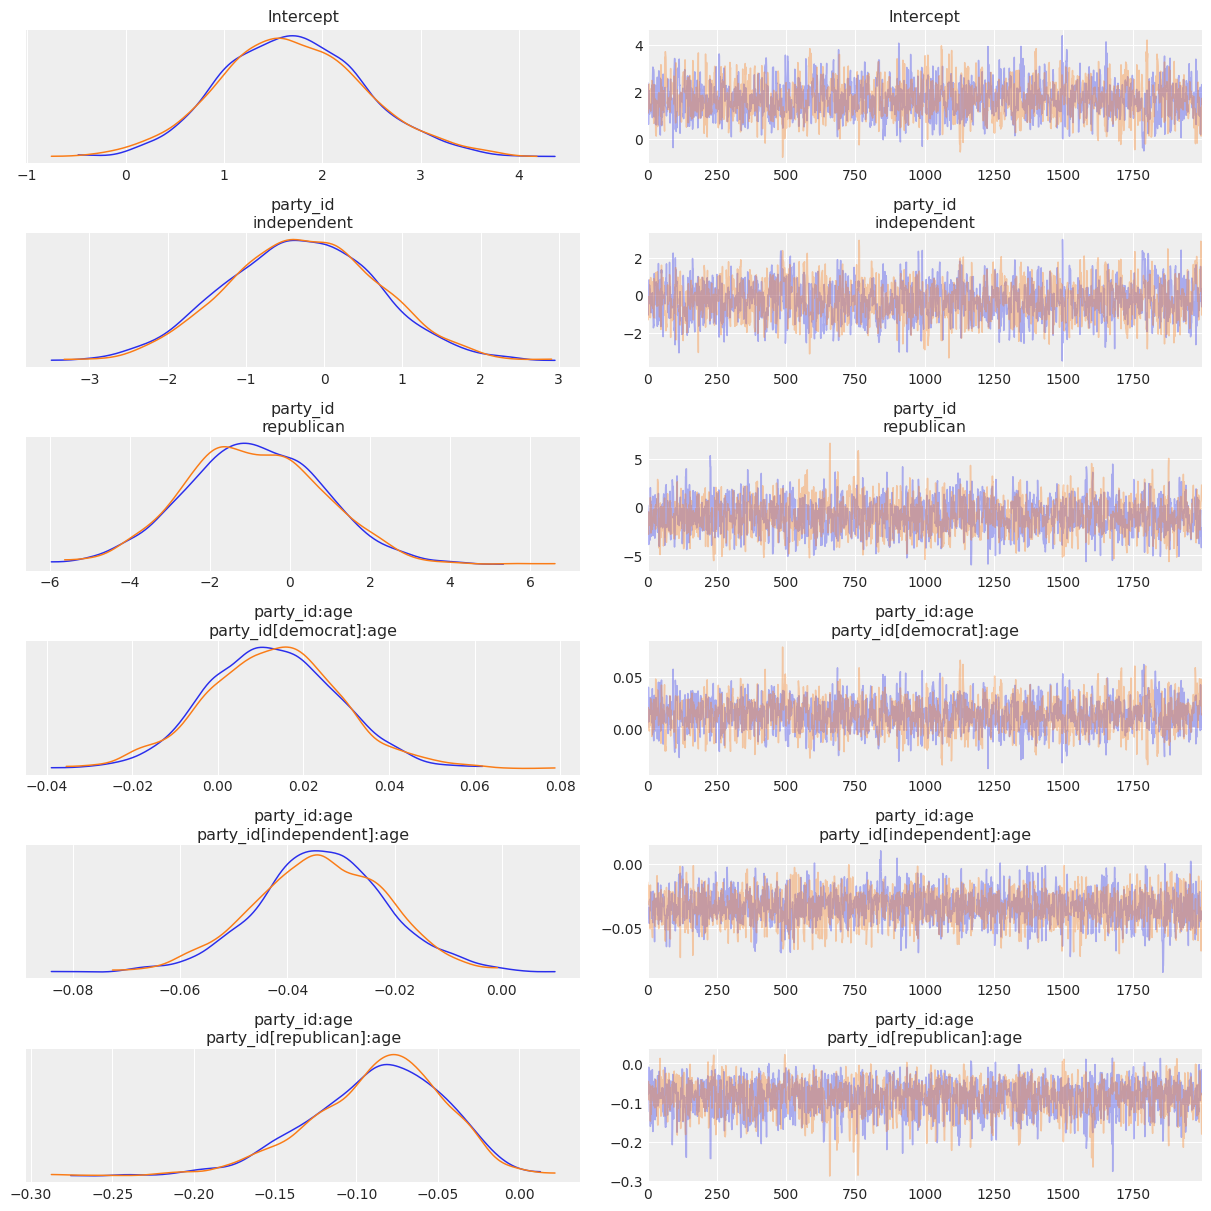

In [12]:
az.plot_trace(clinton_fitted);

In [13]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.698,0.733,0.338,3.115,0.020,0.014,1349.0,1349.0,1343.0,1596.0,1.0
party_id[0],-0.284,0.959,-2.127,1.460,0.026,0.018,1365.0,1365.0,1363.0,1421.0,1.0
party_id[1],-0.899,1.718,-4.140,2.198,0.041,0.029,1770.0,1722.0,1793.0,1873.0,1.0
party_id:age[0],0.013,0.015,-0.015,0.043,0.000,0.000,1410.0,1185.0,1414.0,1725.0,1.0
party_id:age[1],-0.034,0.012,-0.058,-0.011,0.000,0.000,2160.0,2000.0,2183.0,1954.0,1.0
party_id:age[2],-0.087,0.042,-0.165,-0.015,0.001,0.001,1907.0,1612.0,2022.0,1655.0,1.0


## Run Inference

Grab the posteriors samples of the `age` slopes for the three `party_id` categories.

In [14]:
# We need to automatically add labels to InferenceData object to recover this by_label selection
parties = ['democrat', 'independent', 'republican'] 
party_idx = [0, 1, 2]
dem, ind, rep = [clinton_fitted.posterior['party_id:age'][:,:,x].values for x in party_idx]

Plot the marginal posteriors for the `age` slopes for the three political affiliations.

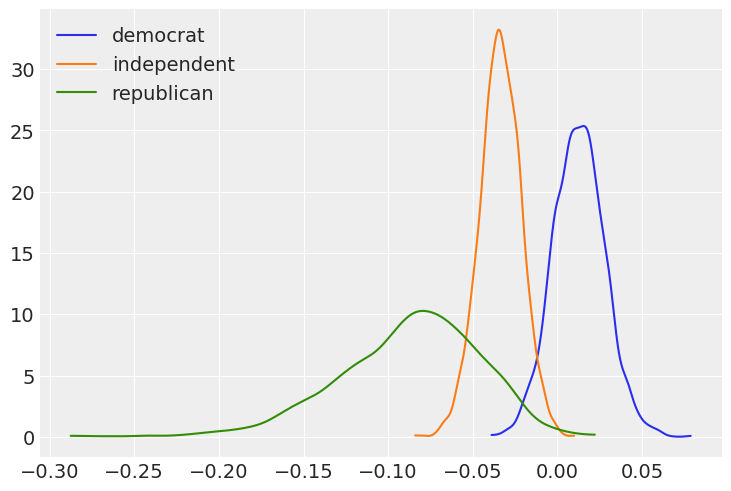

In [15]:
fig, ax = plt.subplots()
for idx, x in enumerate([dem, ind, rep]):
    az.plot_kde(x, label=f'{parties[idx]}', plot_kwargs={'color':f'C{idx}'}, ax = ax)
ax.legend(loc='upper left');

Now, using the joint posterior, we can answer our questions in terms of probabilities.  

What is the probability that the Democrat slope is greater than the Republican slope?

In [16]:
(dem > rep).mean()

0.996

Probability that the Democrat slope is greater than the Independent slope?

In [17]:
(dem > ind).mean()

0.9955

Probability that the Independent slope is greater than the Republican slope?

In [18]:
(ind > rep).mean()

0.9115

Probability that the Democrat slope is greater than 0?

In [19]:
(dem > 0).mean()

0.79125

Probability that the Republican slope is less than 0?

In [20]:
(rep < 0).mean()

0.99425

Probability that the Independent slope is less than 0?

In [21]:
(ind < 0).mean()

0.998

If we look at the plot of the marginal posteriors, we may be suspicious that, for example, the probability that Democrat slope is greater than the Republican slope is 0.996 (almost 1!), given the overlap between the blue and green density functions. However, we can't answer such a question using the marginal posteriors only, as shown in the plot. Since Democrat and Republican slopes ($\beta_3$ and $\beta_5$, respectively) are random variables, we need to use their joint distribution to answer probability questions that involve both of them. The fact that logical comparisons (e.g. `>` in `dem > ind`) are performed elementwise ensures we're using samples from the joint posterior as we should. We also note that when the question involves only one of the random variables, it is fine to use the marginal distribution (e.g. `(rep < 0).mean()`). 

Finally, all these comments may have not been necessary since we didn't need to mention anything about marginal or joint distributions when performing the calculations, we've just grabbed the samples and applied some basic math. But that's an advantage of Bambi and the Bayesian approach. Things that are not so simple, became simpler :)

## Spaghetti plot of model predictions

Here we separate results into two, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`. Then we compute the linear predictor $\eta$ for the different party affiliations and a sequence of `age` values, and plot the estimated values for $\pi$ after passing $\eta$ to `invlogit()`.

In [22]:
slopes = clinton_fitted.posterior['party_id:age'].values.reshape(4000, 3).T

In [23]:
intercept_dem = clinton_fitted.posterior['Intercept'].squeeze().values.reshape(-1,)
intercept_ind = intercept_dem + clinton_fitted.posterior['party_id'][:,:,0].values.reshape(-1,)
intercept_rep = intercept_dem + clinton_fitted.posterior['party_id'][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_ind, intercept_rep]

Compute the predicted values for each posterior sample.

In [24]:
X = np.hstack([np.array([1] * len(np.arange(18, 91)))[:, None], np.arange(18, 91)[:, None]])
yhat = [invlogit(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]

Make the plot!

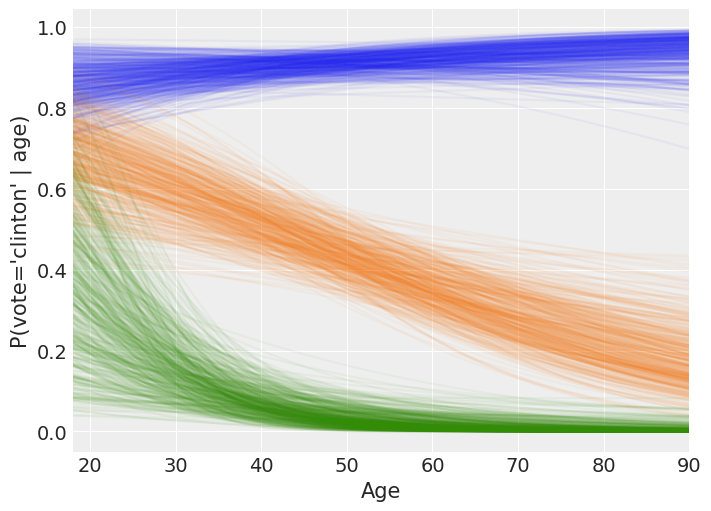

In [25]:
_, axes = plt.subplots(figsize=(7, 5))

for i in range(3):
    for t in range(500):
        axes.plot(X[:, 1], yhat[i][:, t], alpha=0.05, color=f'C{i}')
axes.set_ylabel('P(vote=\'clinton\' | age)')
axes.set_xlabel('Age', fontsize=15)
axes.set_xlim(18, 90);

The following is a rough interpretation of the information contained in the plot we've just created.

According to our logistic model, the mean probability of voting for Clinton is almost always 0.8 or greater for Democrats no matter the age. Also, the older the person, the closer the mean probability of voting Clinton to 1.

On the other hand, Republicans have a non-zero probability of voting for Clinton when they are young, but it tends to zero for older persons. We can also note the high variability of P(vote = 'Clinton') for young Republicans. This reflects our high uncertainty when estimating this probability and it is due to the small amount of Republicans in that age range plus there are only 5 Republicans out of 97 voting for Clinton in the dataset.

Finally, the mean probability of voting Clinton for the independents is around 0.7 for the youngests and decreases towards 0.2 as they get older. Since the spread of the lines is similar along all the ages, we can conclude our uncertainty in this estimate is similar for all the age groups.

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

pandas 1.1.5
arviz  0.10.0
numpy  1.19.4
bambi  0.2.0
last updated: Fri Dec 11 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
